In [9]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

### 1. Data Reading

In [10]:
dataset = load_iris()

In [11]:
print (dataset.DESCR)

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

In [12]:
X,y = dataset.data, dataset.target

In [13]:
X.shape

(150, 4)

In [14]:
y.shape

(150,)

### Reading File using Pandas
Reading data from a csv file and performing the same above operations

In [15]:
import pandas as pd
df = pd.read_csv('iris_dataset.csv')

In [16]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Type
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [17]:
#Slicing and taking features in X and labels in y
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [18]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [19]:
X,y = dataset.data, dataset.target

### Visualization

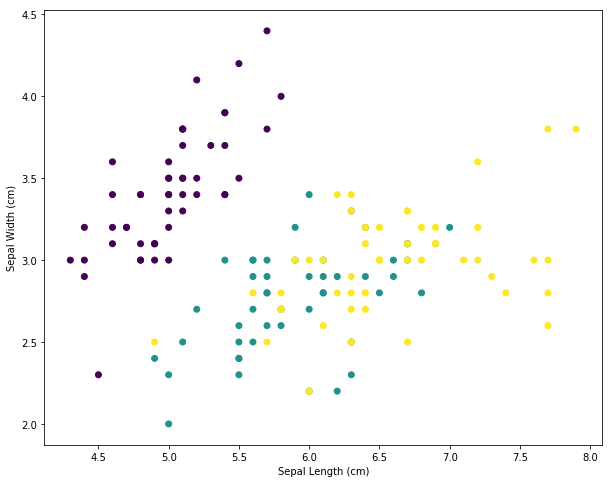

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.scatter(X[:,0], X[:, 1], c=y)
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.show()

### 2. Logistic Regression (Classification)
2.1 Data split

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=32)

In [22]:
#Model fitting
model = LogisticRegression(C=1)
model.fit(x_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### 3. Inference

In [23]:
from sklearn.metrics import accuracy_score

In [24]:
train_predictions = model.predict(x_train)
test_predictions = model.predict(x_test)

In [25]:
print ("Train Accurcay : %.2f"%accuracy_score(y_train, train_predictions))
print ("Test Accuracy : %.2f"%accuracy_score(y_test, test_predictions))

Train Accurcay : 0.97
Test Accuracy : 0.93


In [30]:
from sklearn.metrics import classification_report
print ("Training Classification Report ")
print (classification_report(train_predictions, y_train, target_names=dataset.target_names))
print ("Testing Classification Report ")
print (classification_report(test_predictions, y_test, target_names=dataset.target_names))

Training Classification Report 
             precision    recall  f1-score   support

     setosa       1.00      1.00      1.00        38
 versicolor       0.93      0.97      0.95        39
  virginica       0.98      0.93      0.95        43

avg / total       0.97      0.97      0.97       120

Testing Classification Report 
             precision    recall  f1-score   support

     setosa       1.00      1.00      1.00        12
 versicolor       0.78      1.00      0.88         7
  virginica       1.00      0.82      0.90        11

avg / total       0.95      0.93      0.93        30



### 4. Moving to Cloud
Now we will export and deploy our model to Google Cloud Platform for serving predictions.

In [31]:
from sklearn.externals import joblib

In [18]:
import sys
sys.version

'3.5.2 (default, Nov 23 2017, 16:37:01) \n[GCC 5.4.0 20160609]'

In [32]:
# Export the classifier to a file
joblib.dump(model, 'model.joblib')

['model.joblib']

In [34]:
#Set environment variables

%env PROJECT_ID=steadfast-karma-190320
%env BUCKET_ID=ximistorage/sklearn
%env MODEL_NAME=iris
%env VERSION_NAME=v1
%env REGION=us-central1

env: PROJECT_ID=steadfast-karma-190320
env: BUCKET_ID=ximistorage/sklearn
env: MODEL_NAME=iris
env: VERSION_NAME=v1
env: REGION=us-central1


In [ ]:
#Setting your current project ID
! gcloud config set project $PROJECT_ID

In [33]:
#Copying model to GCP bucket
! gsutil cp ./model.joblib gs://$BUCKET_ID/model.joblib

Copying file://./model.joblib [Content-Type=application/octet-stream]...
- [1 files][   1003 B/   1003 B]                                                
Operation completed over 1 objects/1003.0 B.                                     


In [21]:
#Creating a model on cloud ML engine
! gcloud ml-engine models create $MODEL_NAME --regions us-central1

ERROR: (gcloud.ml-engine.models.create) Resource in project [steadfast-karma-190320] is the subject of a conflict: Field: model.name Error: A model with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A model with the same name already exists.
    field: model.name


In [35]:
#Making a request to accept the model and create a version
! curl -X POST -H "Content-Type: application/json" \
   -d '{"name": "'$VERSION_NAME'", "deploymentUri": "gs://'$BUCKET_ID'/","runtimeVersion": "1.4", "framework": "SCIKIT_LEARN", "pythonVersion": "3.5"}'\
   -H "Authorization: Bearer `gcloud auth print-access-token`" \
    https://ml.googleapis.com/v1/projects/$PROJECT_ID/models/$MODEL_NAME/versions

{
  "name": "projects/steadfast-karma-190320/operations/create_iris_v1-1523687746971",
  "metadata": {
    "@type": "type.googleapis.com/google.cloud.ml.v1.OperationMetadata",
    "createTime": "2018-04-14T06:35:47Z",
    "operationType": "CREATE_VERSION",
    "modelName": "projects/steadfast-karma-190320/models/iris",
    "version": {
      "name": "projects/steadfast-karma-190320/models/iris/versions/v1",
      "deploymentUri": "gs://ximistorage/sklearn/",
      "createTime": "2018-04-14T06:35:46Z",
      "runtimeVersion": "1.4",
      "framework": "SCIKIT_LEARN",
      "pythonVersion": "3.5"
    }
  }
}


In [37]:
#listing the models with their current state
! gcloud ml-engine versions list --model $MODEL_NAME


NAME  DEPLOYMENT_URI             STATE
v1    gs://ximistorage/sklearn/  READY


### 5. Online Predictions
1. Batch Predictions
2. Online Predictions


#### Batch Predictions

In [65]:
#Convert your data instances to JSON instances for serving predictions
import json

# write the test data to a json file
jsondata = {'instances': x_test.tolist()}
with open('input.json', 'w') as outfile:
    json.dump(jsondata, outfile)

In [80]:
%env INPUT_JSON input.json

env: INPUT_JSON=input.json


In [79]:
#Making an API POST call to the HTTP endpoint for making prediction

! curl -X POST -H "Content-Type: application/json" \
-d  @INPUT_JSON \
-H "Authorization: Bearer `gcloud auth print-access-token`" \
https://ml.googleapis.com/v1/projects/$PROJECT_ID/models/$MODEL_NAME:predict

{"predictions": [1, 0, 0, 1, 2, 2, 0, 0, 2, 0, 1, 2, 1, 1, 2, 2, 2, 2, 1, 0, 0, 2, 2, 0, 0, 1, 0, 2, 0, 0]}

#### Online Predictions

In [83]:
with open('input.json', 'w') as outfile:
    json.dump(x_test[0].tolist(), outfile)

In [84]:
#making prediction using gcloud
! gcloud ml-engine predict --model $MODEL_NAME --version $VERSION_NAME --json-instances input.json

[1]
